### Exercise 1.a

- (A) Reading in distance matrices

In [29]:
import numpy as np


def read_file(filename):# it reads the blosum and return score matrices in dictionary
    fh=open(filename)
    line=fh.readline()
    aa_cols=line.split()
    print(aa_cols)
    sm={}
    sm2={}
    for line in fh:
        entries=line.split()
        if not entries:
            continue
        #print(entries)
        row_aa=entries[0]# first entry is the aa
        scores=entries[1:]#following entries are the scores
        # match the scores with the correct column aa
        sm2[row_aa]={}# creating key with empty values
        
        for sc,col_aa in zip(scores,aa_cols):
            #print('the pair alignment {}'. format(row_aa+col_aa,int(sc))
            sm[row_aa+col_aa]=int(sc)
            sm2[row_aa][col_aa]=int(sc)# filling the empty with k,value from column and sc
        #print()
    return sm2

In [30]:
dist=read_file('small-distances.txt')

['A', 'B', 'C', 'D', 'E']


In [31]:
dist

{'A': {'A': 0, 'B': 4, 'C': 1, 'D': 2, 'E': 5},
 'B': {'A': 4, 'B': 0, 'C': 5, 'D': 2, 'E': 3},
 'C': {'A': 1, 'B': 5, 'C': 0, 'D': 3, 'E': 6},
 'D': {'A': 2, 'B': 2, 'C': 3, 'D': 0, 'E': 3},
 'E': {'A': 5, 'B': 3, 'C': 6, 'D': 3, 'E': 0}}

In [32]:
dist['D']['E']

3

- (B) Number of elements of a nested tuple

In [33]:
t=((('A','B'),'C'),('D','E'))
sum(len(x) for x in t)

4

In [34]:
def count_el(tpl):
    if isinstance(tpl,tuple):
        ct =0
        for el in tpl:
            ct+=count_el(el)
        return ct
    else:
        return 1

In [35]:
count_el(t)

5

- (C)  Merging clusters

- write a function [that takes three parameters 1.(distance matrix),2&3(two clusters, can be represented as strings or tuples)] and merges two clusters by updating the distance matrix # after merging there is a need of key removal

In [42]:
def merge_cluster(dist,s1,s2):
    r=count_el(s1)# counting our number of elements in a cluster(r is number)
    s=count_el(s2)#(s is a number now)
    m=(s1,s2)# merging two cluster into one
    dist[m]={}
    for k in dist.keys():
        if k==s1 or k==s2 or k==m:
            continue
        m_dist=(dist[k][s1]*r+dist[k][s2]*s)/(r+s)
        dist[k][m]=m_dist
        dist[m][k]=m_dist# for symetry
    del dist[s1]
    del dist[s2]
    for k in dist.keys():
        if k!=m:
            del dist[k][s1]
            del dist[k][s2]
    return m
            
        
    

- (D) Find closest clusters

In [37]:
def factorial(k):
    """This is a recursive function """
   
        
    if k == 1:
        return 1
    else:
        # recursive call to the function
        return (k * factorial(k-1))

In [38]:
def find_cl_nest(dist):
    
    result_dist=1000
    cl_pair=()
    for s1 in dist:
        for s2 in dist[s1]:
            if dist[s1][s2]<result_dist and s1!=s2:
                result_dist=dist[s1][s2]
                cl_pair=(s1,s2)
    return cl_pair
                
                
            
    

In [39]:
find_cl_nest(dist)

('A', 'C')

- (E) Hierarchical clustering

In [ ]:
#function HierCluster(n,D) # Cluster n ob jects with pairwise distances D
        Let F be the set of all current clusters.
        Initially, F consists of all n one-element clusters C0.
        Each cluster is asso ciated with a height h.
        The height of all initial one-element clusters v is h(C0)=0.
    while There is more than one cluster in F do
        Find the two closest clusters C1,C2 according to D
        Merge C1 and C2 by forming a new cluster C with children C1 and C2.
        Set the height of C to D(C1,C2)/2
        Determine the distance of the new cluster C to all clusters in F \{C1,C2}
        Remove C1 and C2 from F and add C to F
        (Remove the distances from and to C1 and C2 from D.)
    return final vertex in F

In [43]:
def hiercluster(dtxt):
    f=read_file(dtxt)# nested dict
    p={}
    
    for k in f.keys():
        p[k]=0# creating {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    while  len(f)>1:
        
        c1,c2=find_cl_nest(f)# unwrapping 
        h=(f[c1][c2])/2#'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, ('A', 'C'): 0
        m=merge_cluster(f,c1,c2)
        p[m]=h
        #m=(c1,c2)# merging
        
        #removing c1 and c2 from our dict         
    return m,p

        

In [47]:
tree,height=hiercluster('small-distances.txt')

['A', 'B', 'C', 'D', 'E']


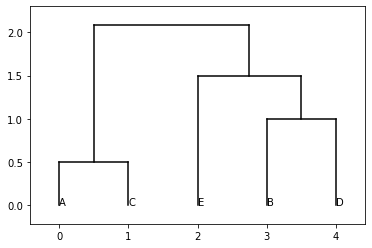

In [48]:
from showtree import showtree
showtree(tree,height)

In [49]:
#distances.txt
tree,height=hiercluster('distances.txt')

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']


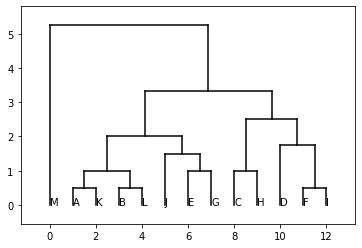

In [50]:
showtree(tree,height)

In [68]:
p={}
dist
for k in dist.keys():
    p[k]=0
len(p)
find_cl_nest(dist)
m=('A', 'C')
p[m]=0
p

{'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, ('A', 'C'): 0}

### 2.RNA secondary structure prediction: The Nussinov algorithm

In [57]:
## Nussinov RNA folding algorithm + backtrack.

import sys

import numpy as np

min_loop_length = 1

def pair_check(tup):
    if tup in [('A', 'U'), ('U', 'A'), ('C', 'G'), ('G', 'C')]:
        return True
    return False
memo={}
def OPT(i,j, sequence):
    """ 
    returns the score of the optimal pairing between indices i and j
    """
    #base case: no pairs allowed when i and j are less than 4 bases apart
    global memo
    if (i,j) in memo:
        return memo[(i,j)]
    if i >= j-min_loop_length:
        return 0
    else:
        #i and j can either be paired or not be paired, if not paired then the optimal score is OPT(i,j-1)
        unpaired = OPT(i, j-1, sequence)

        #check if j can be involved in a pairing with a position t
        pairing = [1 + OPT(i, t-1, sequence) + OPT(t+1, j-1, sequence) for t in range(i, j-min_loop_length)\
                   if pair_check((sequence[t], sequence[j]))]
        if not pairing:
            pairing = [0]
        paired = max(pairing)
        memo[(i,j)]=max(unpaired,paired)


        return max(unpaired, paired)


def traceback(i, j, structure, DP, sequence):
    #in this case we've gone through the whole sequence. Nothing to do.
    if j <= i:
        return
    #if j is unpaired, there will be no change in score when we take it out, so we just recurse to the next index
    elif DP[i][j] == DP[i][j-1]:
        traceback(i, j-1, structure, DP, sequence)
    #consider cases where j forms a pair.
    else:
        #try pairing j with a matching index k to its left.
        for k in [b for b in range(i, j-min_loop_length) if pair_check((sequence[b], sequence[j]))]:
            #if the score at i,j is the result of adding 1 from pairing (j,k) and whatever score
            #comes from the substructure to its left (i, k-1) and to its right (k+1, j-1)
            if k-1 < 0:
                if DP[i][j] == DP[k+1][j-1] + 1:
                    structure.append((k,j))
                    traceback(k+1, j-1, structure, DP, sequence)
                    break
            elif DP[i][j] == DP[i][k-1] + DP[k+1][j-1] + 1:
                #add the pair (j,k) to our list of pairs
                structure.append((k,j))
                #move the recursion to the two substructures formed by this pairing
                traceback(i, k-1, structure, DP, sequence)
                traceback(k+1, j-1, structure, DP, sequence)
                break

def write_structure(sequence, structure):
    dot_bracket = ["." for _ in range(len(sequence))]
    for s in structure:
        dot_bracket[min(s)] = "("
        dot_bracket[max(s)] = ")"
    return "".join(dot_bracket)


#initialize matrix with zeros where can't have pairings
def initialize(N):
    #NxN matrix that stores the scores of the optimal pairings.
    DP = np.empty((N,N))
    DP[:] = np.NAN
    for k in range(0, min_loop_length):
        for i in range(N-k):
            j = i + k
            DP[i][j] = 0
    return DP

def nussinov(sequence):
    N = len(sequence)
    DP = initialize(N)
    structure = []
    global memo
    memo={}

    #fill the DP matrix diagonally
    for k in range(min_loop_length, N):
        for i in range(N-k):
            j = i + k
            DP[i][j] = OPT(i,j, sequence)

    #copy values to lower triangle to avoid null references
    for i in range(N):
        for j in range(0, i):
            DP[i][j] = DP[j][i]


    traceback(0,N-1, structure, DP, sequence)
    return (write_structure(sequence, structure), structure)
if __name__ == "__main__":
    print(nussinov(sys.argv[1]))

('..', [])


### How many base pairs are found?

In [62]:
result=nussinov('AUCGGAGCAUUUUUUGCUCCGACGCAGCCUCAUGCUUUUUU')
result


('(((((((((.)....))))))).((((.)(.))))).....',
 [(0, 35),
  (23, 34),
  (1, 21),
  (2, 20),
  (3, 19),
  (4, 18),
  (5, 17),
  (6, 16),
  (7, 15),
  (8, 10),
  (24, 33),
  (25, 32),
  (29, 31),
  (26, 28)])

In [67]:
print(f' There are 14 base pairs on the given sequence: {len(result[1])}')

 There are 14 base pairs on the given sequence: 14


In [68]:
print(f' The Total length of the given sequence is: {len(result[0])}')

 The Total length of the given sequence is: 41


In [60]:
seqq='AUCGGAGCAUUUUUUGCUCCGACGCAGCCUCAUGCUUUUUU'
print(seqq)
print(result[0])

AUCGGAGCAUUUUUUGCUCCGACGCAGCCUCAUGCUUUUUU
(((((((((.)....))))))).((((.)(.))))).....
